# PRACTICA GUIADA: Análisis de Componentes Principales (PCA)

PCA es una técnica de aprendizaje no supervisado que tiene como objetivo fundamental la reducción de dimensiones. 
Tiene una variedad de aplicaciones:
1. Reducción de la dimensionalidad
2. Visualización
3. Eliminar el ruido
4. Generar nuevos features en el dataset

## 1. Reducción de la dimensionalidad

Vamos a generar algunos puntos en dos dimensiones para tratar de dar una intuición acerca del funcionamiento de PCA.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

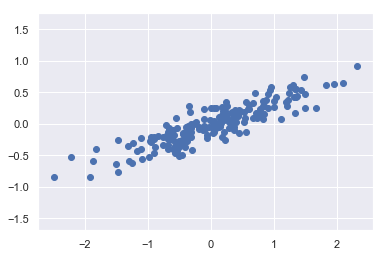

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Generamos dos variables con una relación lineal perturbada por errores que se distribuyen aleatoreamente con distribución normal (por default $\sigma=1$ y $\mu=0$). ¿Hace falta estandarizar las variables en este caso?

Ahora vamos a extaer los componentes principales. En este caso extraemos dos, lo cual no tendría demasiado sentido, dado que buscamos "reducir la dimensionalidad" de este dataset.

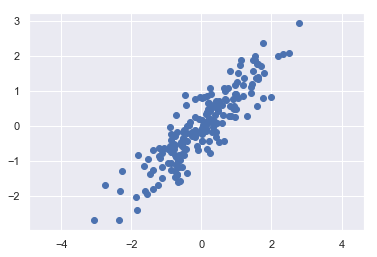

In [3]:
from sklearn.preprocessing import StandardScaler

StdSclr = StandardScaler()
X = StdSclr.fit_transform(X)


plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Cada fila de esta matriz, representa un vector. Los vectores son ortogonales entre sí.

In [5]:
print(pca.components_)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


Veamos la varianza capturada por cada uno de los componentes (en absolutos):

In [6]:
print(pca.explained_variance_)

[1.89888438 0.11116588]


Veamos la varianza capturada por cada uno de los componentes (en relativos). ¿Cuánto deberían sumar la proporción de varianza explicada por estos dos componentes?

In [7]:
pca.explained_variance_ratio_

array([0.94469498, 0.05530502])

Ahora utilizamos PCA para reducir la cantidad de dimensiones de 2 a 1

In [8]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


Usando `pca.transform(X)` reproyectamos los puntos sobre los ejes de los componentes. En este caso, de un solo componente.

A su vez, si Usando `pca.inverse_transform(X)` logramos reproyectar los puntos sobre todo el espacio original (en este caso, reproyectamos los puntos sobre las dos dimensiones originales).

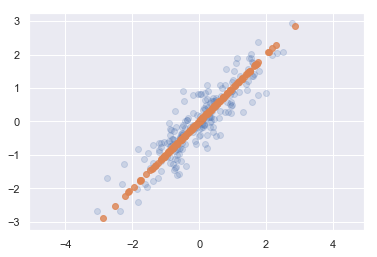

In [9]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

## 2. PCA para visualización

En algunos casos tenemos conjuntos de datos con muchas variables. 
En general, es difícil representar estos datos en un gráfico para ver si se encuentran dispersos, cercanos, agrupados, etc.
¿Hace falta estandarizar en este caso?
Graficar los componentes principales permite una visualización en estos casos.

In [10]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

digits = load_digits()
digits.data.shape

(1797, 64)

Hagamos, entonces, la proyección de 64 a 2 dimensiones a ver qué pasa...

In [11]:
pca = PCA(n_components=2)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


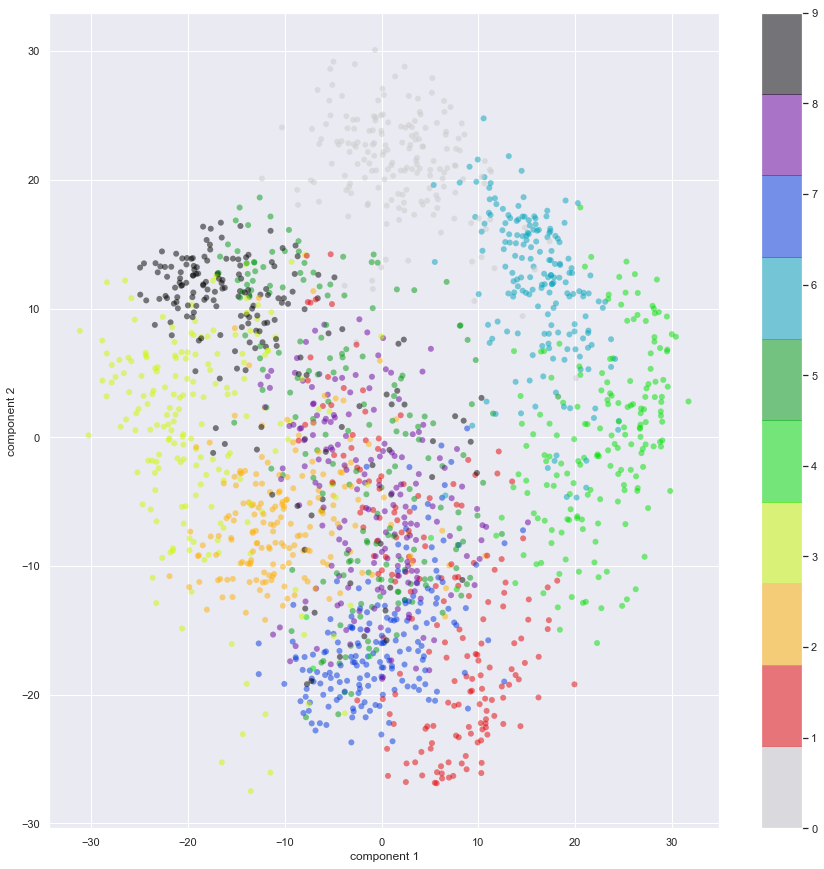

In [12]:
plt.figure(figsize=(15,15))
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral_r', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Lo que hicimos fue encontrar el plano óptimo que nos permite proyectar las 64 dimensiones.
Recordemos que cada dimensión es una combinación lineal de todos los otros píxels.

## Selección de la cantidad de componentes

Cuando la dimensionalidad es tan alta (en este caso 64 variables) ¿Cómo decidimos la cantidad de componentes que necesitamos para llegar a una buena representación de los datos?

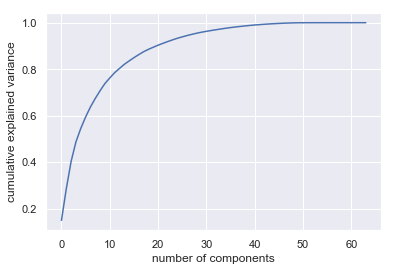

In [13]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [14]:
pca.components_.shape

(64, 64)

No hay una regla "fija" para elegir la cantidad de componentes. Depende del nivel de calidad que se quiera retener. Se puede buscar el punto de la curva donde la varianza explicada empieza a crecer más lentamente a medida que aumentan la cantidad de componentes.

## Reducción de dimensiones en el dataset "digits"

In [15]:
# Esta función sirve para imprimir cada los componentes principales como imágenes

def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx,
             r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

(1797, 8)


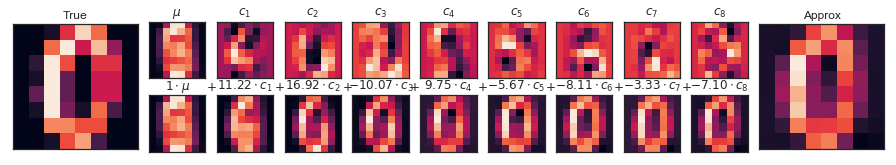

In [16]:
pca = PCA(n_components=8)
Xproj = pca.fit_transform(digits.data)


# Tenemos las 1797 filas, ahora en 8 columnas
print(Xproj.shape)
sns.set_style('white')


# A partir de los valores aproximados que se encuentran en Xproj[10] y los componentes vamos alcanzando el valor 
# aproximado del dígito
#
fig = plot_pca_components(digits.data[10], Xproj[10],
                          pca.mean_, pca.components_)

*Fila superior:* muestra los pixels individuales de los componentes

*Fila inferior:* muestra la contribución acumulativa de cada uno de los componentes para la construcción de la imagen.

Usando solamente 8 de los 64 componentes podemos llegar a una representación bastante buena de la imagen original.

En este caso no estandarizamos los features. ¿Deberíamos haberlo hecho? ¿Tienen la misma varianza los features? ¿Cómo resulta el gráfico anterior con los features estandarizados?

## 3. PCA para eliminar el ruido

PCA puede ser usado también como un "filtro de ruido". La intuición es la siguiente: cada componente con variancia mucho más grande que el ruido debería verse relativamente poco o nada afectado por dicho ruido. Entonces, si reconstruimos los datos usando solamente los componentes de mayor varianza debería ser posible conservar la mayor parte de la señal y descartar la mayor parte del ruido.

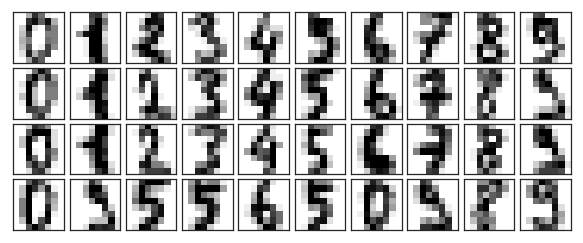

In [17]:
import matplotlib
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Para probar esta funcionalidad de PCA, vamos a introducir ruido al dataset:

In [18]:
print(digits.data.mean())
print(digits.data.std())

4.884164579855314
6.016787548672236


`digits.data` tiene media 4.88 y desvío estándar de 6.06.

Para introducir ruido le sumamos errores aleatorios que se distribuyen normal con media 0 y desvío 4.

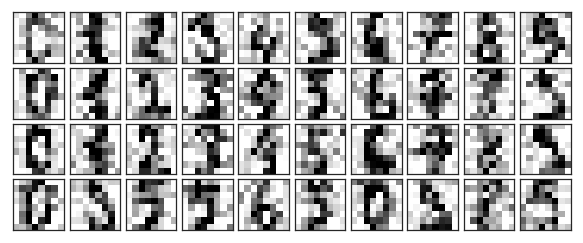

In [19]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)


Vamos a correr PCA para retener con la cantidad de componentes principales necesaria para explicar el 50% de la varianza.

In [20]:

pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Primero calculamos los componentes para el dataset ruidoso

In [21]:
components = pca.transform(noisy)
components.shape

(1797, 12)

 Luego aplicamoso la transformación inversa, que a partir de los componentes reconstruyó los valores de las x originales.
 
**¿CUÁNTOS COMPONENTES DESCARTAMOS AL EXPLICAR SÓLO EL 50% DE LA VARIANZA?**


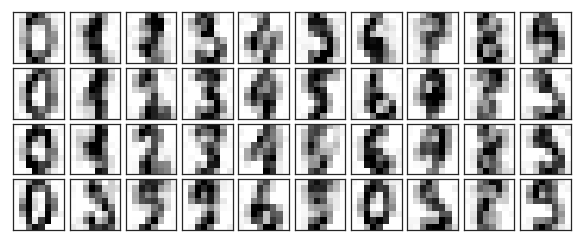

In [22]:
filtered = pca.inverse_transform(components)
plot_digits(filtered)

El dataset resultante es más difuso que el original pero el ruido no persiste.